<a href="https://colab.research.google.com/github/Vodolay/NovaJax/blob/Jiucheng/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Install jax if necessary
!pip install --upgrade -q "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [25]:
# Install flax if necessary
!pip install -q git+https://github.com/google/flax

  Preparing metadata (setup.py) ... done


In [26]:
# Install clu and upgrade jaxlib if necessary
!pip install --upgrade -q jaxlib clu

In [27]:
import jax
import jax.numpy as jnp

from flax import linen as nn
import optax
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [28]:
# There is no need for tensorflow to use the gpu; it is only dataloading
tf.config.experimental.set_visible_devices([], "GPU")

In [29]:
# This finction loads the MNIST dataset into memory

def get_datasets(num_epochs, batch_size):
  train_ds = tfds.load('mnist', split='train') # 60,000 images (28x28)
  test_ds = tfds.load('mnist', split='test') # 10,000 images (28x28)
  
  # Let's cast the pixel values into floats and normalize them
  train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'], tf.float32) / 255.,
                                          'label': sample['label']})
  test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'], tf.float32) / 255.,
                                        'label': sample['label']})

  train_ds = train_ds.repeat(num_epochs).shuffle(10*batch_size) # allocating a buffer to randomly draw elements from
  train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
  test_ds = test_ds.shuffle(10*batch_size) # allocating a buffer to randomly draw elements from
  test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency

  return train_ds, test_ds

In [110]:
# Setting up a template; the parameters (kernels, biases, etc.) are a separate object
class CNN(nn.Module):
    
  # __call__ subsumes __init__  
  @nn.compact
  def __call__(self, x, training):
    '''
    # Shape is (1, 28, 28, 1)
    x = nn.Conv(features=4, kernel_size=(3, 3))(x)
    # Shape is (1, 28, 28, 32)
    x = nn.gelu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    # Shape is (1, 14, 14, 32)
    x = nn.Conv(features=8, kernel_size=(3, 3))(x)
    # Shape is (1, 14, 14, 64)
    x = nn.gelu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    # Shape is (1, 7, 7, 64)
    x = x.reshape((x.shape[0], -1))  # flatten but keep batch dimension
    # Shape is (1, 3136 = 7x7x64)
    x = nn.Dense(features=64)(x)
    x = nn.Dropout(rate=0.3, deterministic=not training)(x)
    # Shape is (1, 256)
    x = nn.gelu(x)
    x = nn.Dense(features=10)(x)
    # Shape is (1, 10)
    '''

   # Shape is (1, 28, 28, 1)
    x = nn.Conv(features=16, kernel_size=(3, 3))(x)
    x = nn.gelu(x)
    # Shape is (1, 28, 28, 16)
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.gelu(x)
    # Shape is (1, 28, 28, 32)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    # Shape is (1, 14, 14, 32)
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.gelu(x)
    # Shape is (1, 14, 14, 64)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.gelu(x)
    # Shape is (1, 7, 7, 64)
    x = nn.Conv(features=128, kernel_size=(3, 3))(x)
    x = nn.gelu(x)
    # Shape is (1, 7, 7, 128)
    x = x.reshape((x.shape[0], -1))  # flatten but keep batch dimension
    # # Shape is (1, 6272 = 7x7x128)
    x = nn.gelu(x)
    x = nn.Dense(features=256)(x)
    x = nn.Dropout(rate=0.3, deterministic=not training)(x)
    # Shape is (1, 256)
    x = nn.gelu(x)
    x = nn.Dense(features=128)(x)
    # Shape is (1, 128)
    x = nn.gelu(x)
    x = nn.Dense(features=84)(x)
    x = nn.Dropout(rate=0.3, deterministic=not training)(x)
    # Shape is (1, 84)
    x = nn.gelu(x)
    x = nn.Dense(features=10)(x)
    # Shape is (1, 10)

    return x

In [111]:
# To create a summary for the Module instantiate with template data
print(CNN().tabulate(jax.random.PRNGKey(0), jnp.ones((1, 28, 28, 1)), training=False))


                                  CNN Summary                                   
┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path      ┃ module  ┃ inputs           ┃ outputs          ┃ params           ┃
┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│           │ CNN     │ -                │ float32[1,10]    │ Conv_0:          │
│           │         │ float32[1,28,28… │                  │   bias:          │
│           │         │ - training:      │                  │ float32[16]      │
│           │         │ False            │                  │   kernel:        │
│           │         │                  │                  │ float32[3,3,1,1… │
│           │         │                  │                  │ Conv_1:          │
│           │         │                  │                  │   bias:          │
│           │         │                  │                  │ float32[32]      │
│           │         │    

Let's create a single dataclass that represents the entire training state, including step number, parameters, and optimizer state. This class will subclass flax.training.train_state.TrainState 

The clu library contains utils for common ML training loops. Here we will use it for evaluation metrics.

In [112]:
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses which could be safely processed with JAX 

In [113]:
# A set of metrics in a safe dataclass
@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

In [114]:
class TrainState(train_state.TrainState):
  # Our train state will have metrics attribute
  metrics: Metrics
  # It will also have a dropout key
  key: jax.random.KeyArray

In [115]:
# We also need JAX PRNGKey for the parameter initialization
root_key = jax.random.PRNGKey(42)
main_key, params_key, dropout_key = jax.random.split(key=root_key, num=3)

In [116]:
# Initialize the model
cnn = CNN()
# initialize parameters by passing a template image
params = cnn.init(params_key, 
                jnp.ones([1, 28, 28, 1]), 
                training=False)['params']

In [117]:
# The optimizer parameters
learning_rate = 0.0007

In [118]:
# Lets create the training state
# The Module foward pass will be in the TrainState apply function. 
state = TrainState.create(
      apply_fn=cnn.apply, 
      params=params, 
      key=dropout_key, 
      tx=optax.adam(learning_rate),
      metrics=Metrics.empty())

The training step takes the following actions on a batch:
    
    1. Takes a forward pass with the current state parameters.
    2. Evaluates cross entropy loss.
    3. Evaluates the gradient of the loss function with jax.grad
    4. Applies a pytree of gradients to update the model parameters.
    
We trace the entire train_step function and just-in-time compile it with XLA.

In [119]:
@jax.jit
def train_step(state, batch, dropout_key):
  # New PRNG key for the dropout  
  dropout_train_key = jax.random.fold_in(key=dropout_key, data=state.step)
  #Below the loss function will be evaluated with the current state parameters
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, 
                batch['image'],
                training=True, 
                rngs={'dropout': dropout_train_key}) #Log(prob_i)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

We want to compute metrics during validation and testing, so their computation will be in a separate function. The lone * indicates that all following arguments are keyword-only arguments, that is, they can only be provided using their name, not as positional argument.

In [120]:
@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'],
                training=False)
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch['label'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

In [121]:
# Let's assure tfds shuffles are reproducible
tf.random.set_seed(42)

In [122]:
num_epochs = 32
batch_size = 32

# Download, shuffle, batch the data with the function we defined
train_ds, test_ds = get_datasets(num_epochs, batch_size)

In [123]:
len(train_ds), len(test_ds)
# (60000/32*10, 10000/32)

(60000, 312)

In [124]:
# since train_ds is replicated num_epochs times in get_datasets(), we divide by num_epochs
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs

In [125]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

Finally we are ready to run training

In [126]:
for step,batch in enumerate(train_ds.as_numpy_iterator()):

  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch, dropout_key) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_ds.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.11730627715587616, accuracy: 96.57666778564453
test epoch: 1, loss: 0.058484021574258804, accuracy: 98.2071304321289
train epoch: 2, loss: 0.03139999136328697, accuracy: 99.14500427246094
test epoch: 2, loss: 0.041354745626449585, accuracy: 98.87820434570312
train epoch: 3, loss: 0.02114202454686165, accuracy: 99.42333984375
test epoch: 3, loss: 0.0488467738032341, accuracy: 98.818115234375
train epoch: 4, loss: 0.01422802172601223, accuracy: 99.61333465576172
test epoch: 4, loss: 0.031926460564136505, accuracy: 99.16867065429688
train epoch: 5, loss: 0.011936263181269169, accuracy: 99.66166687011719
test epoch: 5, loss: 0.03532331809401512, accuracy: 99.03846740722656
train epoch: 6, loss: 0.009197620674967766, accuracy: 99.75
test epoch: 6, loss: 0.040643543004989624, accuracy: 98.99839782714844
train epoch: 7, loss: 0.0072388299740850925, accuracy: 99.7933349609375
test epoch: 7, loss: 0.03452008217573166, accuracy: 99.22876739501953
train epoch: 8, loss: 0.0

Let's visualize the metrics during training

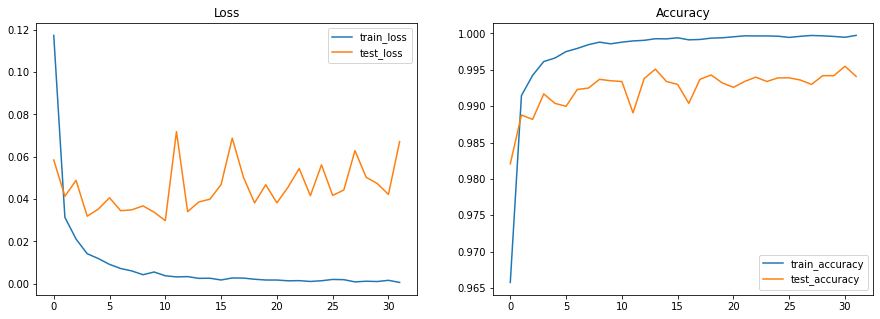

<Figure size 432x288 with 0 Axes>

In [127]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

And we can do inference on a test set.

In [128]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, test_batch['image'], training=False)
  return logits.argmax(axis=1)

test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(state, test_batch)

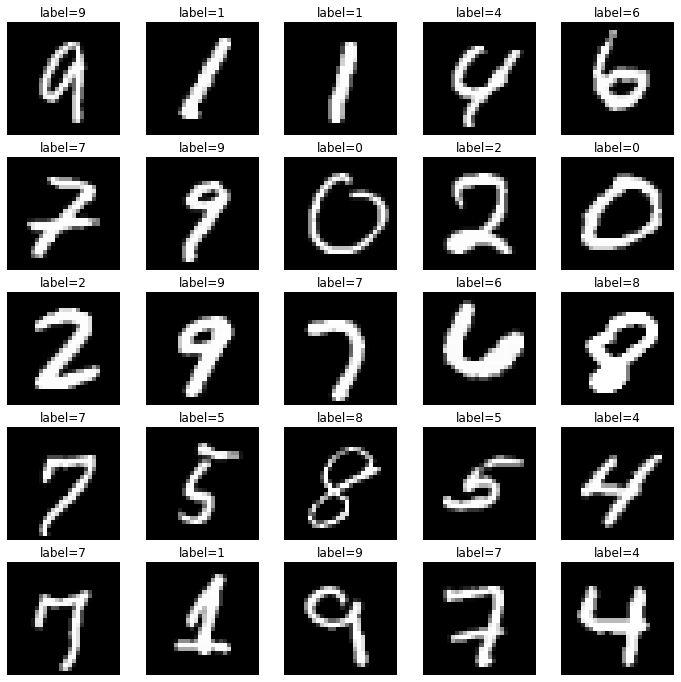

In [129]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={pred[i]}")
    ax.axis('off')

Homework: Play with the layers of the Model, the activation function and the hyperparameters to achieve Test accuracy over 99.5%

Push your code to GitHub on branch carrying your name.